In [18]:
# fit xgboost on an imbalanced classification dataset
import pandas as pd
import glob
import os
import json
import numpy as np
import inspect
import sys
import math
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer,accuracy_score,classification_report, recall_score,confusion_matrix, matthews_corrcoef, roc_auc_score,balanced_accuracy_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import missingno as msno

In [19]:
df_input = pd.read_csv('../output/model_data_with_nan.csv', sep=',', header=0)

In [20]:
df_input.head()

,Child,isInfluencer,influencer_ratio_total,WC,affect,drives,social,polarity,health,cogproc,...,esteem_score,fas,socialmedia_freq,socialmedia_days,socialmedia_hours,vlog_freq,vlog_self,vlog_learn,age,sex
0,1046,0,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.90,8.0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,1
1,1047,0,0.108333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0
2,1049,0,0.070833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.45,8.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,0
3,1050,0,0.087500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,0
4,1055,0,0.094444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,0


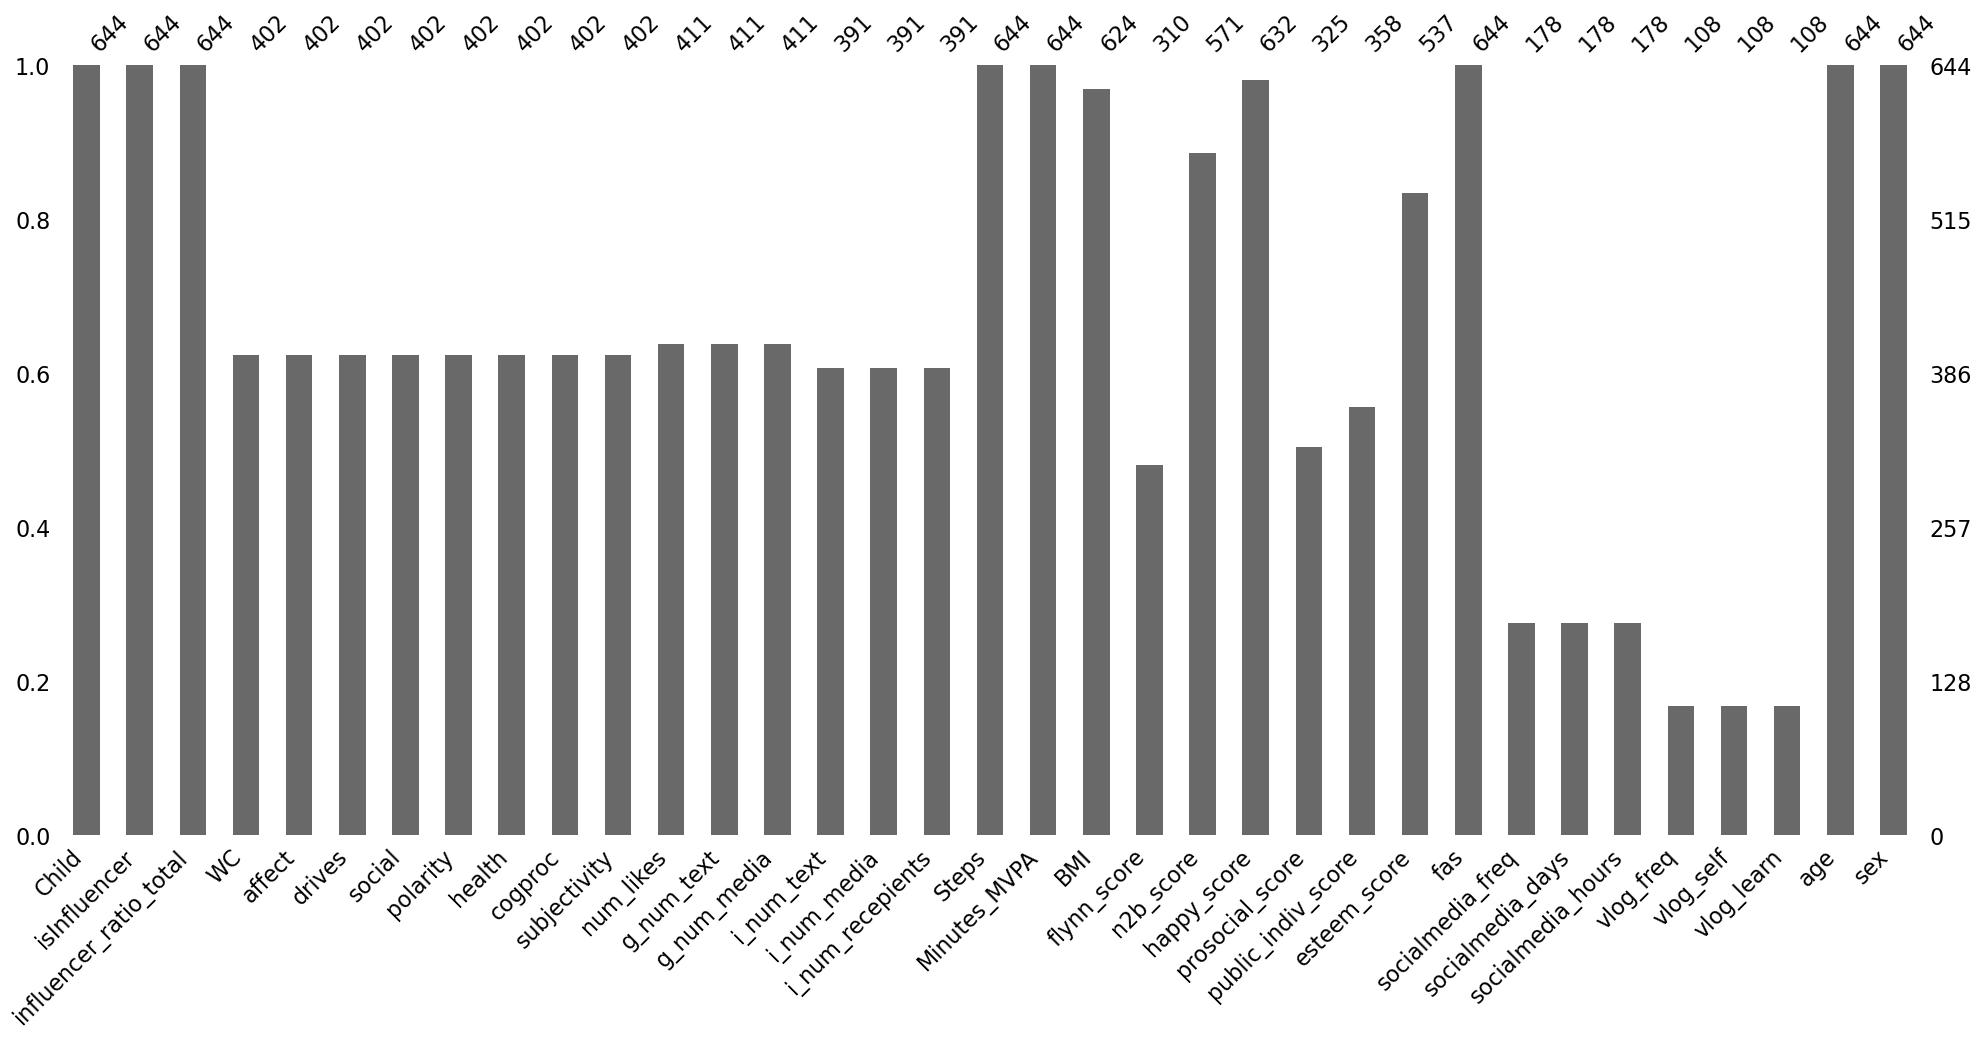

In [22]:
msno.bar(df_input)
plt.show()

In [23]:
df_input = df_input.drop(['Child','isInfluencer','socialmedia_freq', 'socialmedia_days', 'socialmedia_hours',
       'vlog_freq', 'vlog_self', 'vlog_learn'], axis=1)

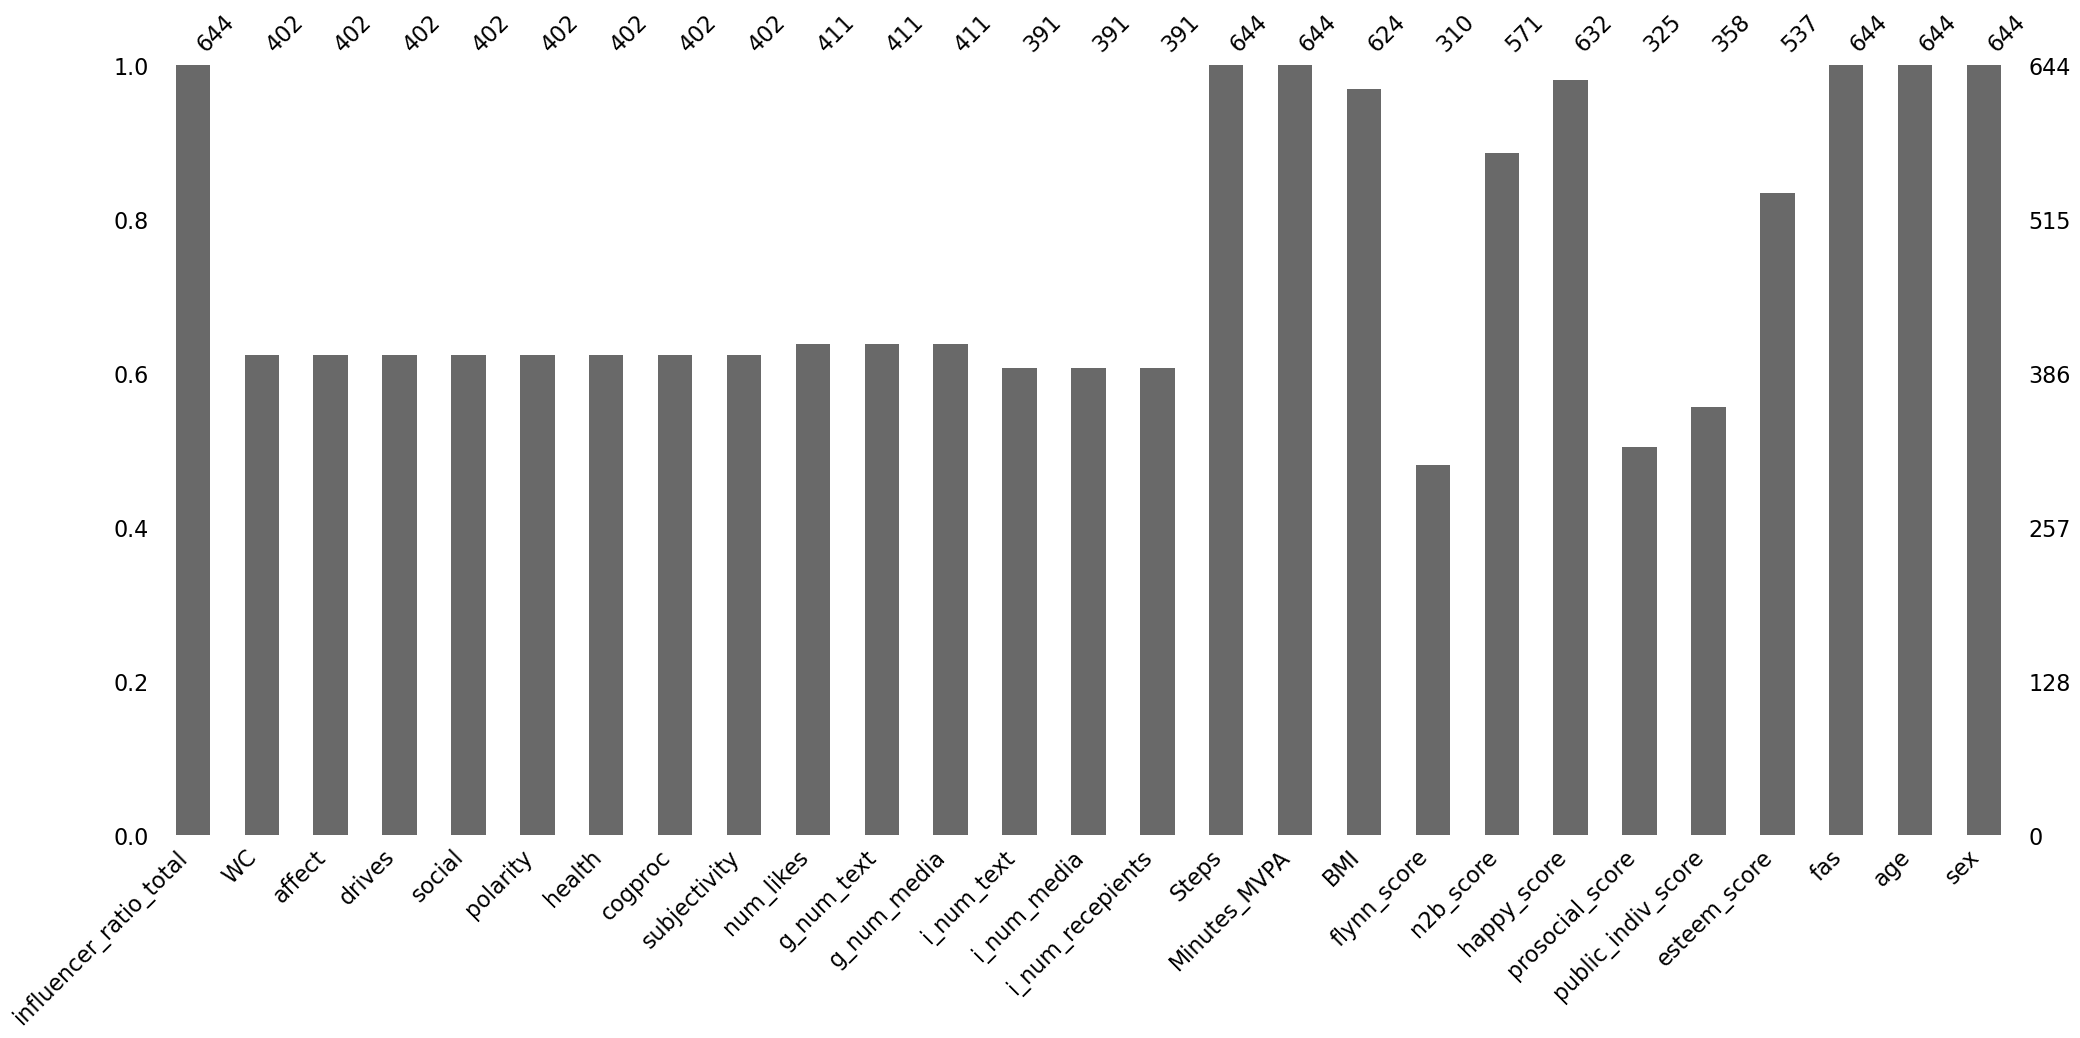

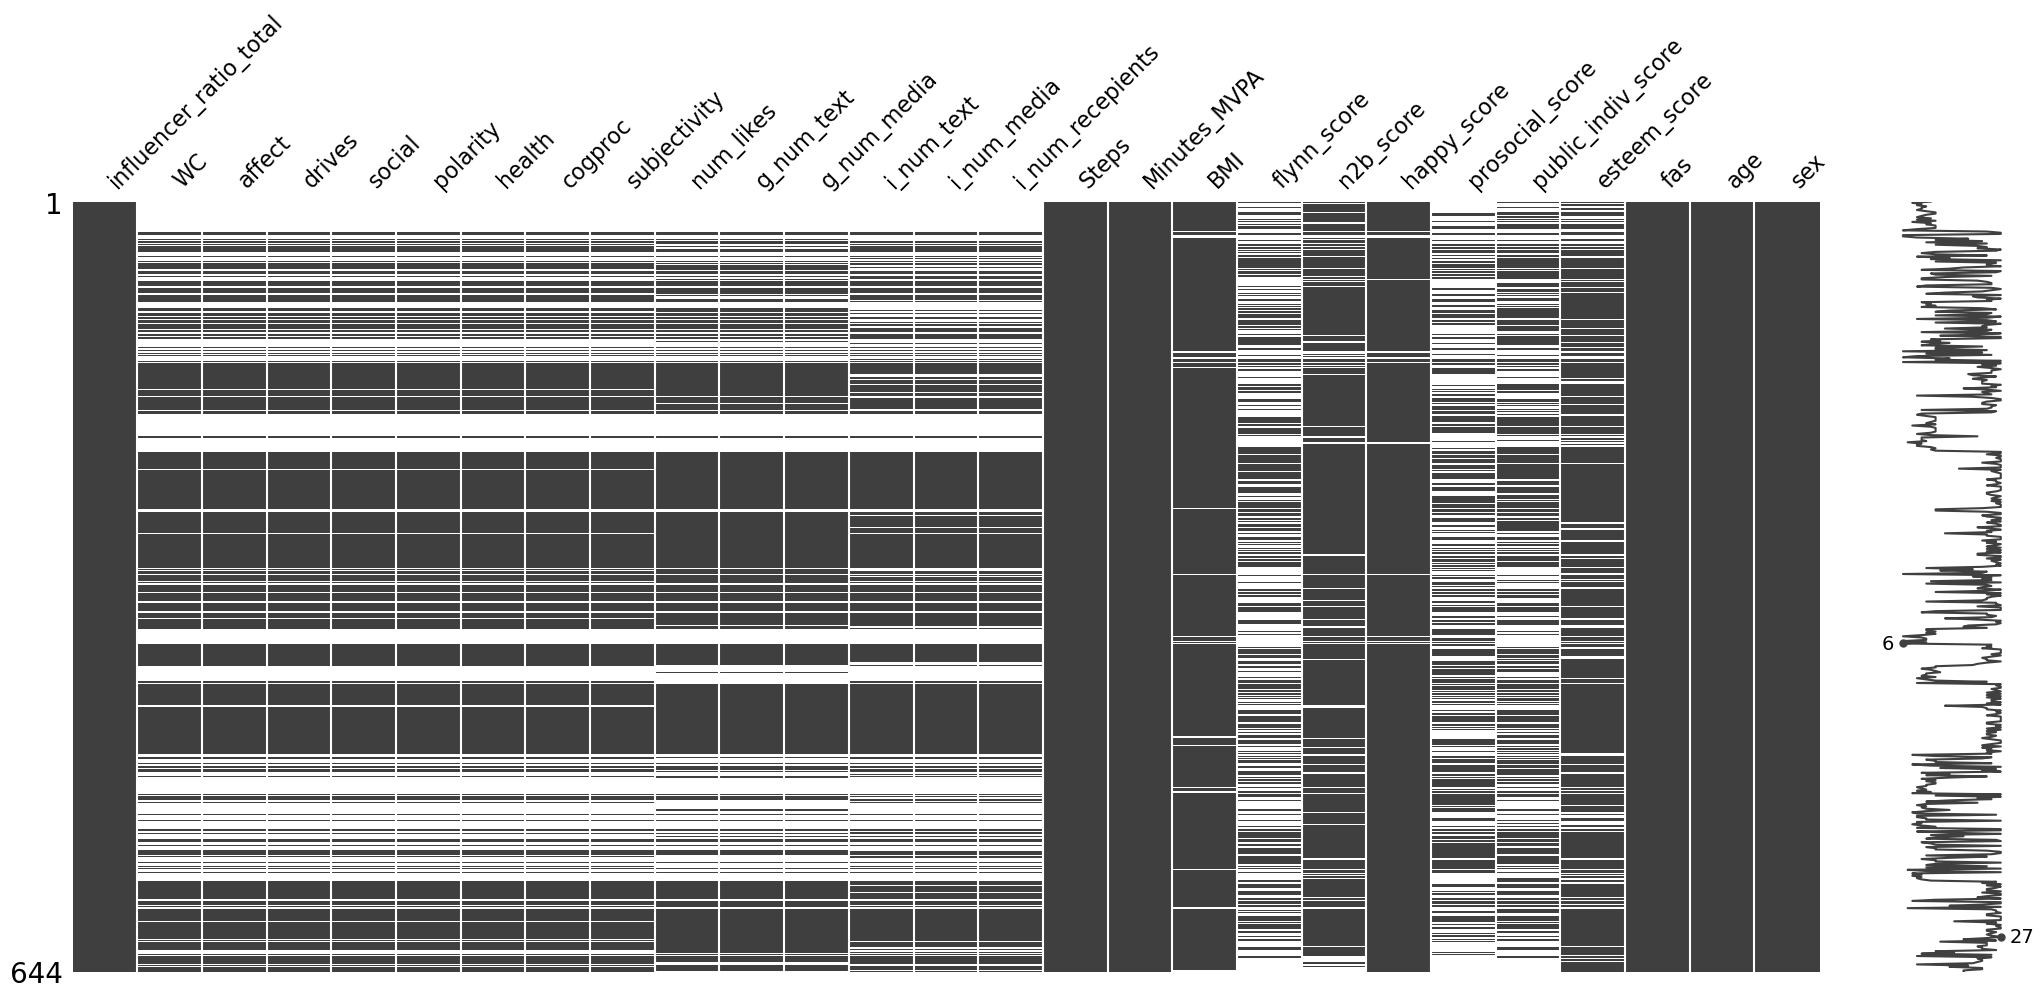

In [24]:
msno.bar(df_input)
msno.matrix(df_input)
plt.show()

In [107]:
X = df_input.drop('influencer_ratio_total', axis=1)
y = df_input['influencer_ratio_total']

In [111]:
X = X.fillna(X.mean())
df_input = df_input.fillna(df_input.mean())

### Check for corelations between target and features

In [109]:
features = X.columns.tolist()
target = 'influencer_ratio_total'

In [112]:
from scipy.stats import pearsonr

correlations = {}
for f in features:
    data_temp = df_input[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [113]:
correlations

{'WC vs influencer_ratio_total': 0.0326113179144964,
 'affect vs influencer_ratio_total': 0.031186131550257457,
 'drives vs influencer_ratio_total': 0.02748968525294349,
 'social vs influencer_ratio_total': 0.037058011814545294,
 'polarity vs influencer_ratio_total': -0.022399890361464222,
 'health vs influencer_ratio_total': -0.008141826156010324,
 'cogproc vs influencer_ratio_total': 0.002171040586997724,
 'subjectivity vs influencer_ratio_total': 0.050483524830445596,
 'num_likes vs influencer_ratio_total': 0.04157301273605078,
 'g_num_text vs influencer_ratio_total': -0.035998985173321105,
 'g_num_media vs influencer_ratio_total': -0.07532131160396527,
 'i_num_text vs influencer_ratio_total': 0.032716642164833123,
 'i_num_media vs influencer_ratio_total': -0.00983445992534343,
 'i_num_recepients vs influencer_ratio_total': -0.02746468891810063,
 'Steps vs influencer_ratio_total': 0.16006588691740894,
 'Minutes_MVPA vs influencer_ratio_total': 0.035414989296504884,
 'BMI vs influenc

In [81]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [82]:
xgbr = xgb.XGBRegressor(verbosity=0) 


In [84]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [85]:
score = xgbr.score(X_train, y_train)  

In [86]:
score

0.9997107467549134

In [87]:
scores = cross_val_score(xgbr,X_train, y_train,cv=10)


In [88]:
print("Mean cross-validation score: %.2f" % scores.mean())


Mean cross-validation score: -0.18


In [92]:
from sklearn.model_selection import  KFold

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: -0.22


In [98]:
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))


MSE: 0.01
RMSE: 0.07


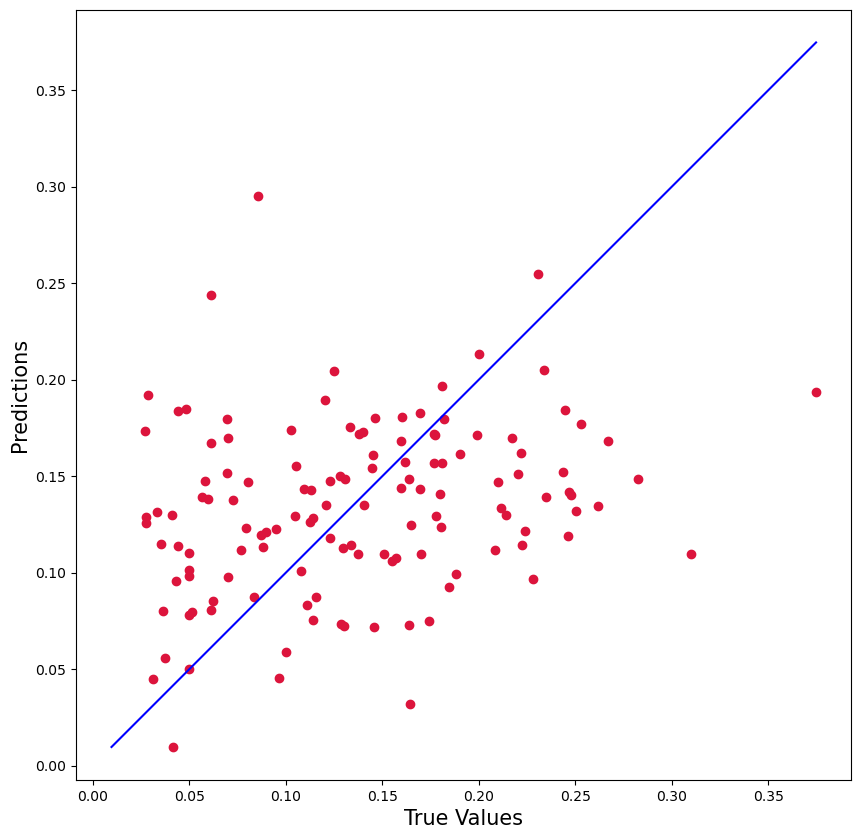

In [97]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()